In [33]:
library(tidyverse)
library(pinyin)

# Preprocess

## Read Data and make it tidy

In [34]:
#From github
ds <- read.csv("https://raw.githubusercontent.com/ZackYe42/STAT344-GroupProject/main/China_AQI.csv",header = T)
reg <- read.csv("https://raw.githubusercontent.com/ZackYe42/STAT344-GroupProject/main/china_city_list.csv",header = T)

#From Local
#ds <- read.csv("China_AQI.csv",header = T) # AQI data
#reg <- read.csv("china_city_list.csv",header = T) # Region data

# Select Data
ds <- ds[,5:379]
column_means <- colMeans(ds, na.rm = T)
ds <- data.frame(AirQuality = column_means) %>% rownames_to_column(var = "city")

In [35]:
head(ds,5)

,city,AirQuality
,<chr>,<dbl>
1,北京,55.53574
2,天津,63.25470
3,石家庄,76.76514
4,唐山,64.82182
5,秦皇岛,53.41774


In [36]:
# Convert Chinese to pinyin
mypy <- pydic(method = 'toneless',dic = "pinyin2")
ps <- py(ds$city,dic = mypy)

ds1 <- ds
ds1$city <- data.frame(ps)$ps

head(ds1)
N <- nrow(ds1)
N

,city,AirQuality
,<chr>,<dbl>
1,bei_jing,55.53574
2,tian_jin,63.25470
3,shi_jia_zhuang,76.76514
4,tang_shan,64.82182
5,qin_huang_dao,53.41774
6,han_dan,82.18667


[1] 375

# Visulization

Warning message:
"Removed 31 rows containing non-finite values (`stat_boxplot()`)."


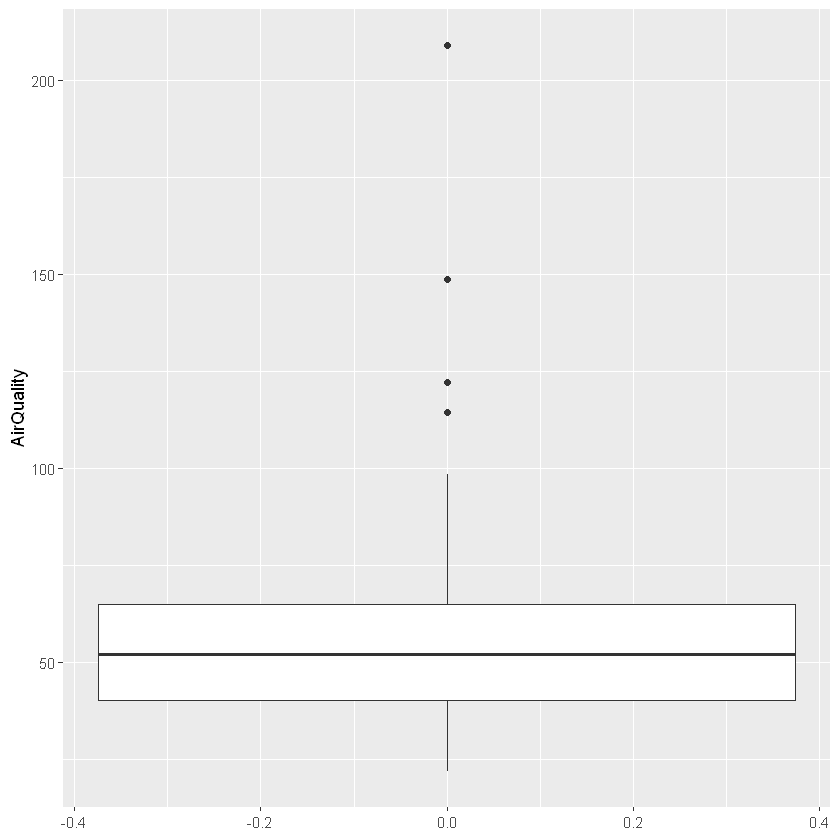

In [37]:
air_box <- ds1 %>% 
    ggplot() +
    geom_boxplot(aes(y = AirQuality))
air_box


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 31 rows containing non-finite values (`stat_bin()`)."


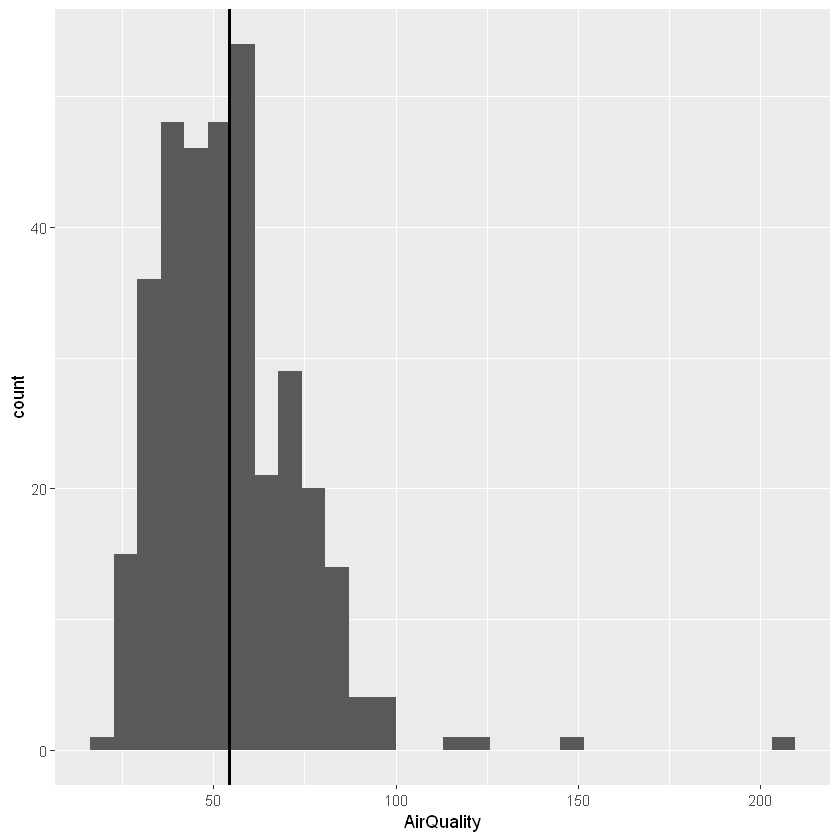

In [38]:
air_srs_mu <- mean(ds1$AirQuality,na.rm = T)
air_hist <- ds1 %>% 
    ggplot() +
    geom_histogram(aes(x = AirQuality)) + 
    geom_vline(aes(xintercept = air_srs_mu), size = 1)
air_hist

# True Mean and Proportion

In [39]:
air_mu <- mean(ds1$AirQuality,na.rm = T)
air_prop <- mean(ds1$AirQuality <= 50, na.rm = T)

cat("The mean for chinese air quality is ", air_mu,
   "\nThe proportion for chinese air quality not larger than 50 is ", air_prop)

The mean for chinese air quality is  54.16269 
The proportion for chinese air quality not larger than 50 is  0.4505814

## SRS Method

In [40]:
# SRS Sample 

set.seed(42)
n <- 50
srs <- sample_n(ds1,n)

In [41]:
# FPC
fpc <- (1 - n / N)

### Mean and SE

In [42]:
#Calculate Mean and SE

air_srs_mu <- mean(srs$AirQuality, na.rm = T)
air_srs_mu_se <- sd(srs$AirQuality, na.rm = T) / sqrt(n / fpc)

# CI
air_srs_mu_CI <- air_srs_mu + qt(0.95,n) * c(-1, 1) * air_srs_mu_se


cat("The mean for SRS air quality is ", air_srs_mu, ", the se for it is ", air_srs_mu_se, 
    "\nThe 95% Confidence Interval for that is ", air_srs_mu_CI[1], " and ", air_srs_mu_CI[2])

The mean for SRS air quality is  57.79385 , the se for it is  2.63517 
The 95% Confidence Interval for that is  53.37755  and  62.21014

### Proportion and SE  

Equal Samller or Larger than 50, the proportion will reflect the AQI **Equal Samller than 50**


In [43]:
#Calculate Proportion and SE
air_srs_prop <- mean(srs$AirQuality <= 50, na.rm = T)
air_srs_prop_se <- sqrt(air_srs_prop * (1 - air_srs_prop) / n * fpc)

air_srs_prop_CI <- air_srs_prop + qt(0.95,n) * c(-1, 1) * air_srs_prop_se

cat("The proportion for SRS air quality not larger than 50 is ", air_srs_prop, ", the se for it is ", air_srs_prop_se, 
    "\nThe 95% Confidence Interval for that is ", air_srs_prop_CI[1], " and ", air_srs_prop_CI[2])

The proportion for SRS air quality not larger than 50 is  0.4042553 , the se for it is  0.06460989 
The 95% Confidence Interval for that is  0.2959753  and  0.5125354

# Stratified 

In [44]:
# Use for select North City
north_city <- reg %>% 
    select(City,Region)  %>% 
    filter(Region == "North" | Region == "West") %>% 
    pull(City)
head(north_city)

[1] "七台河" "三门峡" "东营"   "中卫"   "临汾"   "临沂"

In [45]:
north <- ds %>% 
    filter(city %in% north_city)

`%notin%` <- Negate(`%in%`)
south <- ds %>% 
    filter(city %notin% north_city)

N_nor <- nrow(north)
N_sou <- nrow(south)

w_nor <- N_nor / N
w_sou <- N_sou / N

n_nor <- round(w_nor * n,0)
n_sou <- round(w_sou * n,0)

fpc_nor <- 1 - n_nor / N
fpc_sou <- 1 - n_sou / N

In [46]:
# Stratified Sample
#set.seed(42)
str_nor <- sample_n(north,n_nor)
str_sou <- sample_n(south,n_sou)

### Mean and SE

In [47]:
#Calculate Mean and SE

# Mean
air_str_n_mu <- mean(str_nor$AirQuality, na.rm = T)  
air_str_s_mu <- mean(str_sou$AirQuality, na.rm = T)  

air_str_mu <- w_nor * air_str_n_mu + w_sou * air_str_s_mu


# SE  
air_str_n_mu_se <- sqrt(w_nor^2 * fpc_nor * var(str_nor$AirQuality, na.rm = T) / n_nor)  
air_str_s_mu_se <- sqrt(w_sou^2 * fpc_sou * var(str_sou$AirQuality, na.rm = T) / n_sou)  

air_str_mu_se <- sqrt(air_str_n_mu_se^2 + air_str_s_mu_se^2)

# CI
air_str_mu_CI <- air_str_mu + qt(0.95,n) * c(-1, 1) * air_str_mu_se

cat("The mean for Stratified air quality is ", air_str_mu, ", the se for it is ", air_str_mu_se, 
    "\nThe 95% Confidence Interval for that is ", air_str_mu_CI[1], " and ", air_str_mu_CI[2])

The mean for Stratified air quality is  54.2414 , the se for it is  2.301197 
The 95% Confidence Interval for that is  50.38481  and  58.09799

### Proportion and SE  

Equal Samller or Larger than 50, the proportion will reflect the AQI **Equal Samller than 50**


In [48]:
#Calculate Proportion and SE

# Proportion
air_str_n_prop <- mean(str_nor$AirQuality <= 50, na.rm = T)  
air_str_s_prop <- mean(str_sou$AirQuality <= 50, na.rm = T)  

air_str_prop <-  w_nor * air_str_n_prop + w_sou * air_str_s_prop

# SE
air_str_n_prop_se <- sqrt(w_nor^2 * fpc_nor * air_str_n_prop * (1 - air_str_n_prop) / (n_nor))  
air_str_s_prop_se <- sqrt(w_sou^2 * fpc_sou * air_str_s_prop * (1 - air_str_s_prop) / (n_sou))  

air_str_prop_se <- sqrt(air_str_n_prop_se^2 + air_str_s_prop_se^2)

# CI
air_str_prop_CI <- air_str_prop + qt(0.95,n) * c(-1, 1) * air_str_prop_se

cat("The proportion for Stratified air quality not larger than 50 is ", air_str_prop, ", the se for it is ", air_str_prop_se, 
    "\nThe 95% Confidence Interval for that is ", air_str_prop_CI[1], " and ", air_str_prop_CI[2])

The proportion for Stratified air quality not larger than 50 is  0.4655556 , the se for it is  0.06190672 
The 95% Confidence Interval for that is  0.3618058  and  0.5693053